In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.preprocessing import scale
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import warnings

warnings.filterwarnings("ignore")

def preprocess_data(df, features_columns, label=None, z_score=False, standardize=False):
    print("------------------------------------------")
    print("            Preprocessing data            ")
    print("------------------------------------------")
    print("Get dataset")
    print("Shape of the data to process : " + str(df.shape))
    print("------------------------------------------")

    # Create inputs and labels
    # label
    if label is not None:
        print("Extract labels ...")
        df_labels = df['genre']

    # inputs
    print("Extract inputs ...")
    df = df[features_columns]
    # Remove outliers
    if z_score:
        print("Remove outliers with zscore ...")
        z_scores = zscore(df)
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 4).all(axis=1)
        df = df[filtered_entries]
        if label is not None:
            df_labels = df_labels[filtered_entries]

    # Strandardize : center reduce
    if standardize:
        print("Center and reduce inputs ...")
        df = scale(df, axis=0, with_mean=True, with_std=True)
        df = pd.DataFrame(df, columns=features_columns)

    print("------------------------------------------")
    print("Data shape after preprocessing : " + str(df.shape))
    if label is not None:
        print("Labels shape : " + str(df_labels.shape))

    print("Return dataset(s) ...")
    print("Preprocessing finished")
    print("------------------------------------------")

    if label is not None:
        df_labels = pd.DataFrame(df_labels, columns=["genre"])
        res = (df, df_labels)
    else:
        res = df

    return res

In [ ]:
import pandas as pd
from google.colab import files
import io

uploaded = files.upload()

Saving Spotify_train_dataset.csv to Spotify_train_dataset.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['Spotify_train_dataset.csv']))

In [ ]:
uploaded = files.upload()

Saving Spotify_test_dataset.csv to Spotify_test_dataset.csv


In [ ]:
df_compet = pd.read_csv(io.BytesIO(uploaded['Spotify_test_dataset.csv']))

In [ ]:
features_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms', 'time_signature']

label = 'genre'

le = LabelEncoder()
df_label_encoded = le.fit_transform(df[label])

df_standardized = preprocess_data(df, features_columns, standardize=True)
print(f"Shape dataframe original standardized :{df_standardized.shape}")
print(df_standardized.head())

df_compet_std =  preprocess_data(df_compet, features_columns, standardize=True)
print(f"Shape dataframe original standardized :{df_compet_std.shape}")
print(df_compet_std.head())


------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
Center and reduce inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original standardized :(31728, 13)
   danceability    energy       key  ...     tempo  duration_ms  time_signature
0     -1.218835  0.251085  0.170192  ... -0.205069    -0.165303        0.099669
1     -0.137354 -0.593423 -0.102914  ... -0.815282     1.091947        0.099669
2      0.361791  0.725100  0.443298  ... -0.813267     2.468967        0.099669
3      0.828939 -1.399793 -1.468445  ... -1.148954    -0.187234        0.099669
4     -1.532400 -0.473558  1.535723  ...  0.955920    -0.691188        0.099669

[5 rows x 13 colu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV


X_train,X_test,y_train,y_test = train_test_split(df_standardized,
                                                 df_label_encoded,
                                                 test_size=0.30,
                                                 random_state=5)

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(random_state=5, max_depth=13, n_estimators=300)),
    ('knn', KNeighborsClassifier(n_neighbors=24, p=1)),
    ('svc', SVC())
]

meta_model = LogisticRegressionCV()

stacking_model = StackingClassifier(estimators=estimators,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2,
                                    n_jobs=-1)

In [ ]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=13,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                          

In [ ]:
y_pred = stacking_model.predict(X_test)

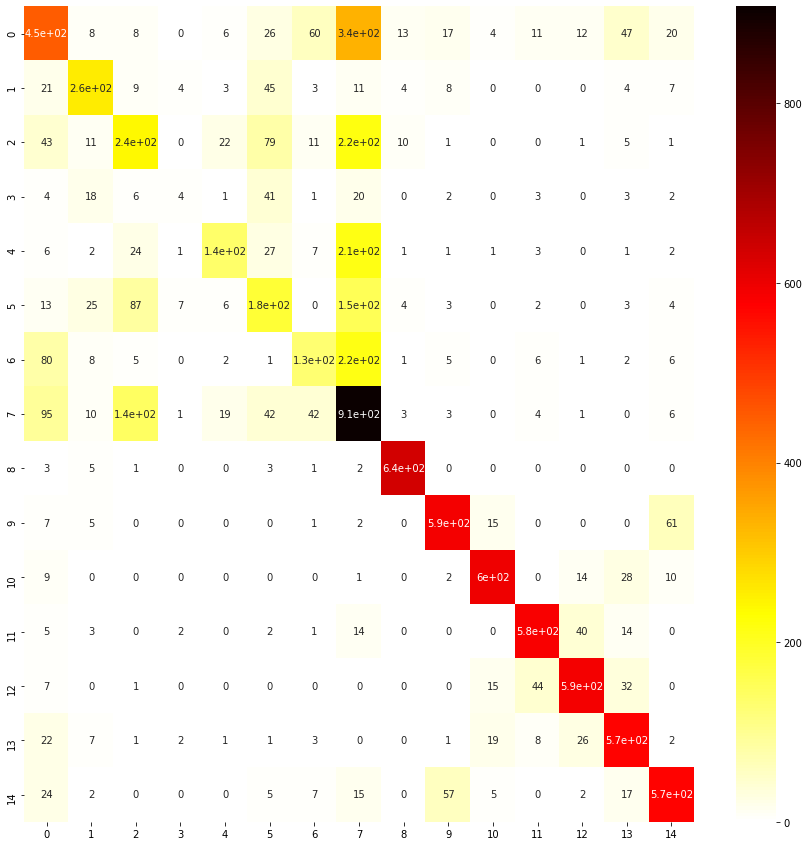

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='hot_r')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
f_score = 2 * (precision * recall) / (precision + recall)

print(f"f_score : {f_score}")
print(f"Accuracy : {accuracy}")

                 precision    recall  f1-score   support

      Dark Trap       0.57      0.44      0.50      1020
            Emo       0.71      0.68      0.70       377
         Hiphop       0.46      0.37      0.41       639
            Pop       0.19      0.04      0.06       105
            Rap       0.69      0.32      0.44       426
            RnB       0.40      0.37      0.38       488
     Trap Metal       0.49      0.28      0.36       462
Underground Rap       0.43      0.71      0.54      1277
            dnb       0.95      0.98      0.96       651
      hardstyle       0.86      0.87      0.86       683
      psytrance       0.91      0.90      0.91       662
      techhouse       0.88      0.88      0.88       666
         techno       0.86      0.86      0.86       691
         trance       0.79      0.86      0.82       665
           trap       0.83      0.81      0.82       707

       accuracy                           0.68      9519
      macro avg       0.67   

In [ ]:
y_compet = stacking_model.predict(df_compet_std)



In [ ]:
prediction_labels = le.inverse_transform(y_compet)


df_prediction_labels = pd.DataFrame({'genre' : prediction_labels})
df_prediction_labels.to_csv('Stacking prediction.csv')

files.download('Stacking prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>